## Практическая работа №1. Азат Сибагатулин

In [ ]:
 !pip install scipy matplotlib statsmodels pandas seaborn tqdm scikit-learn numba tweedie

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from tweedie.tweedie_dist import tweedie_gen

import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from typing import Callable
from base64 import b64encode
import collections
import datetime

from numba import njit, float32
from joblib import Parallel, delayed

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 20000)

## Загрузка KION датасета

In [ ]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [ ]:
# Распаковываем архив из 3 файлов
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

## 1. Извлекаем просмотры 

- за две последних недели ```week2```

In [4]:
interactions = pd.read_csv('data_kion/interactions_df.csv')

interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

In [5]:
max_date = interactions['last_watch_dt'].max()

week2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week2 = week2.groupby('user_id', as_index=False)["total_dur"].sum()
week2.total_dur = week2.total_dur.astype(np.int32)

del interactions

In [6]:
print("Уникальных пользователей за две недели:", week2.user_id.nunique())

Уникальных пользователей за две недели: 279129


- Удаление выбросов ```total_dur```

In [13]:
print(f"Week2(total_dur): mean={week2.total_dur.mean():.0f} std={week2.total_dur.std():.0f}")

Week2(total_dur): mean=21896 std=74516


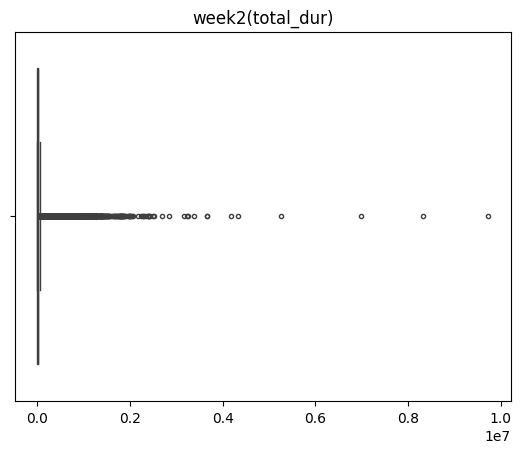

In [10]:
sns.boxplot(week2['total_dur'].values, fliersize=3, orient='h').set_title('week2(total_dur)');

In [14]:
# Удалим выбросы в 3-х стандартных отклонениях

print(week2.shape)
week2 = week2[(week2['total_dur'] < week2['total_dur'].std() * 3)]
print(week2.shape)

(279129, 2)
(275616, 2)


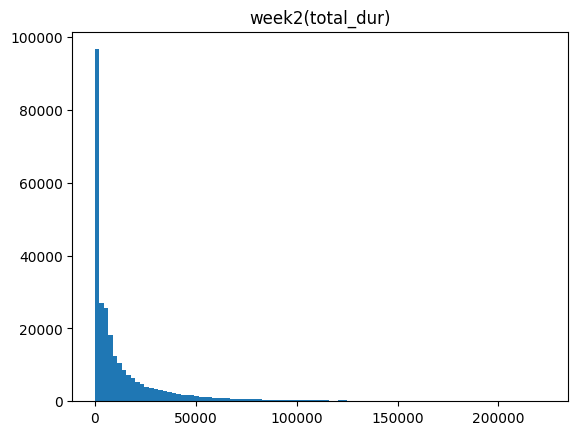

In [16]:
week2['total_dur'].hist(bins=100, grid=False).set_title("week2(total_dur)");

In [17]:
print(f"Week2(total_dur): mean={week2.total_dur.mean():.0f} std={week2.total_dur.std():.0f}")

Week2(total_dur): mean=16222 std=28341


## 2. Подбор пары: метрика + статистический тест

In [18]:
def salt_generator() -> str:
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df: pd.DataFrame, 
                    columns: list[str], 
                    user_salt: str | None = None) -> pd.DataFrame:
    salt = user_salt if user_salt else salt_generator()
    
    df = df.copy()
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))
    return df[columns]


def calc_pvalue(week: pd.DataFrame, 
                col: str = 'total_dur', 
                criterion: Callable = stats.mannwhitneyu) -> float:
    week_groups = groups_splitter(week, columns=['user_id', col, 'group'])
    _, p = criterion(
        week_groups[week_groups['group'] == 'A'][col].values,
        week_groups[week_groups['group'] == 'B'][col].values
    )
    return p


Валидация:

**Распределение ```p_value```** при корректном подборе пары метрика + критерий - равномерное распределение

**Корректность** - вероятность того, что найдет различие, когда его нет

$$significance = P(\text{reject }H_0 | H_0 \text{ is true})$$
$$ \alpha = significance $$

**Мощность** - вероятность того, что критерий найдет различие в случае, когда оно есть

$$power = P(\text{reject }H_0 | H_1 \text{ is true})$$
$$ \beta = 1 - power = P(\text{accept }H_0 | H_1 \text{ is true}) $$


In [19]:
metric_column = "total_dur"

- **Манна-Уитни**:

CPU times: total: 1min 58s
Wall time: 4min 4s


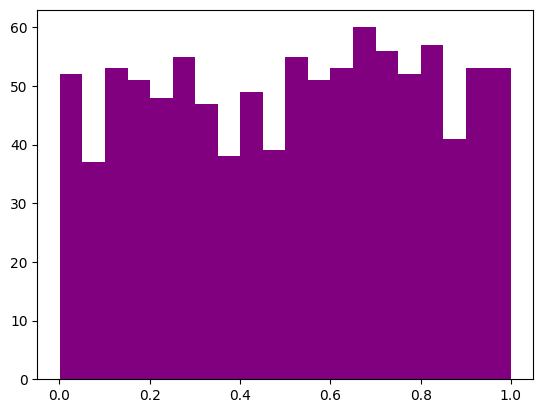

In [20]:
%%time
criterion=stats.mannwhitneyu

pvalues_week2 = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week2, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week2, bins=20, color='purple');

In [21]:
stat, p_value = scipy.stats.kstest(pvalues_week2, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week2)
print("I type error: ", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.23430875387568695 - p_values равномерное распределение
I type error:  0.051


- **t-test**:

CPU times: total: 1min 41s
Wall time: 2min 46s


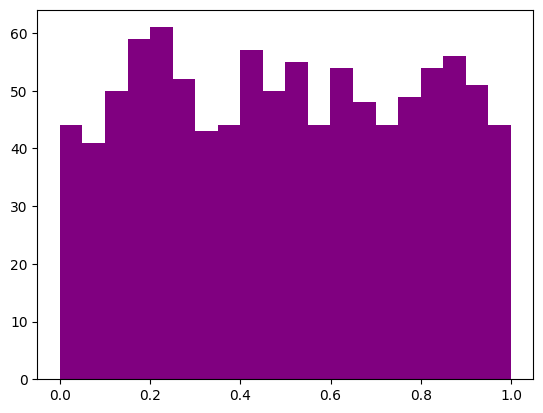

In [22]:
%%time
criterion=stats.ttest_ind

pvalues_week2_ttest = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week2, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week2_ttest, bins=20, color='purple');

In [23]:
stat, p_value = scipy.stats.kstest(pvalues_week2_ttest, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week2_ttest)
print("I type error: ", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.8484785028403148 - p_values равномерное распределение
I type error:  0.044


**Вывод**:

- все распределения ```p_values``` равномерны
- ошибка первого рода варьируется около 0.05 для t-test и Манна-Уитни в зависимости от разбиения

## 3. Дизайн A/B на Бутстрапе

In [37]:
N = 1000

### 3.1. Корректность

In [38]:
@njit(parallel=True)
def calc_bootstrap_mean(arr: np.array, size = 1000) -> np.array:
    samplings = np.empty(size, dtype=float32)
    for i in range(size):
        sampling = np.random.choice(arr, size=arr.size, replace=True)
        mean = np.mean(sampling)
        samplings[i] = mean
    return samplings


def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue


def bootstrap_correctness(week: pd.DataFrame, metric_column: str, alpha=0.05) -> (np.array, bool):
    new_df = groups_splitter(week, columns=['user_id', metric_column, 'group'])

    vec_a = new_df[(new_df['group'] == 'A')][metric_column]
    vec_b = new_df[(new_df['group'] == 'B')][metric_column]

    sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
    diff_mean = sample_a_mean - sample_b_mean

    # Compute the confidence interval (e.g., 95% CI)
    left_side, right_side = np.percentile(diff_mean, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    # Reject equality of means when it's true
    is_this_first_type_error = not left_side <= 0 <= right_side
    
    return get_p_value(diff_mean), is_this_first_type_error


def test_correctness(week, metric_column):
    result = Parallel(n_jobs=-1)(delayed(bootstrap_correctness)(week, metric_column) for _ in range(N))

    p_values = [x[0] for x in result]

    first_type_errors = [x[1] for x in result]
    alpha = sum(first_type_errors) / len(first_type_errors)

    print(f"I type error: {alpha:.2f}")

    stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
    if p_value < 0.05:
        print(f'p_value = {p_value} - p_values неравномерное распределение')
    else:
        print(f'p_value = {p_value} - p_values равномерное распределение')
    return p_values, alpha

In [39]:
metric_column="total_dur"

In [32]:
%%time

p_values, alpha = test_correctness(week2, metric_column)

I type error: 0.05
p_value = 0.023344526390774223 - p_values неравномерное распределение
CPU times: total: 2min 31s
Wall time: 14min 16s


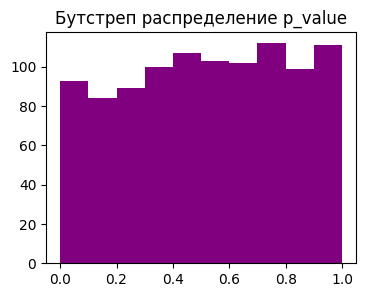

In [33]:
plt.rcParams["figure.figsize"] = (4,3)
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value");

### 3.2. Мощность

In [40]:
def generate_tweedie(mu, shape, p=1.5, phi=25):
    tw = tweedie_gen()
    return tw(p=p, mu=mu, phi=phi).rvs(shape)


def bootstrap_power(week: pd.DataFrame, metric_col: str, effect: float, alpha=0.05) -> (np.array, bool):
    new_df = groups_splitter(week, columns=['user_id', metric_col, 'group'])

    vec_a = new_df[(new_df['group'] == 'A')][metric_col]
    vec_b = new_df[(new_df['group'] == 'B')][metric_col]

    # Effect
    tw_values = generate_tweedie(effect * vec_b.mean(), vec_b.size)
    vec_b += tw_values

    sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
    diff_mean = sample_a_mean - sample_b_mean

    # Compute the confidence interval (e.g., 95% CI)
    left_side, right_side = np.percentile(diff_mean, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    # Do not reject the equality of means when it's necessary to reject
    is_this_second_type_error = left_side <= 0 <= right_side

    return is_this_second_type_error


def test_power(week, metric_column, effect):
    second_type_errors = Parallel(n_jobs=-1)(delayed(bootstrap_power)(week, metric_column, effect) for _ in range(N))

    beta = sum(second_type_errors) / len(second_type_errors)    
    print(f"II type error: {beta:.2f}")
    
    return beta

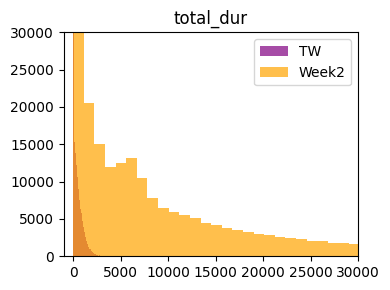

In [47]:
effect = 0.03
tw = generate_tweedie(effect * week2.total_dur.mean(), week2.total_dur.size)

plt.hist(tw, bins=100, color='purple', alpha=0.7, label='TW')
plt.hist(week2.total_dur, bins=200, color='orange', alpha=0.7, label='Week2')
plt.legend()
plt.title('total_dur')
plt.ylim([0, 30000])
plt.xlim([-1000, 30000])
plt.tight_layout()

- Эффект 1%:

In [36]:
%%time

effect = 0.01
metric_column="total_dur"

beta = test_power(week2, metric_column, effect)

II type error: 0.68
CPU times: total: 2min 38s
Wall time: 14min 51s


- Эффект 3%:

In [38]:
%%time

effect = 0.03
metric_column="total_dur"

beta = test_power(week2, metric_column, effect)

II type error: 0.01
CPU times: total: 2min 37s
Wall time: 15min 3s


- Эффект 5%:

In [40]:
%%time

effect = 0.05
metric_column="total_dur"

beta = test_power(week2, metric_column, effect)

II type error: 0.00
CPU times: total: 2min 37s
Wall time: 15min 1s


- Эффект в 1% плохо детектируется
- Эффект в 3% детектируется в 99% случаев
- Эффект в 5% детектируется в более чем 99% случаев

Стоит учесть что здесь я добавлял Tweedie эффект, а не увеличивал просмотры топ-10% пользователей, как в итоговом A/B тесте из домашнего задания.
Поэтому разные эффекты могут давать разные $\alpha$ и $\beta$

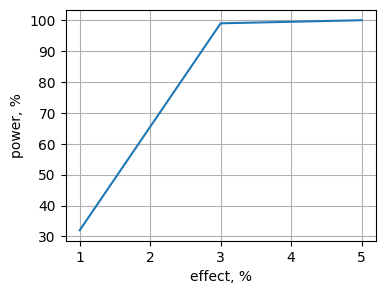

In [84]:
plt.plot([1, 3, 5], [32, 99, 100])
plt.grid()
plt.ylabel("power, %")
plt.xlabel("effect, %");

### 3.3. Оценка MDE

$$ MDE = \frac{(z_{1 - \frac{\alpha}{2}} + z_{1 - \beta}) * \sqrt{\sigma_{control}^2 + \sigma_{experiment}^2}}{\sqrt{N}} $$

In [48]:
from scipy.stats import norm


def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [85]:
first_type_errors = [0.05, 0.1]
second_type_errors = [0.68, 0.5, 0.2, 0.1, 0.05, 0.01]

In [86]:
mde_week2 = []

for a in first_type_errors:
    mdes = {str(b): f"{get_mde(week2.total_dur, alpha=a, beta=b):.1f}%" for b in second_type_errors}
    mdes["alpha"] = a
    mde_week2.append(mdes)
    
pd.DataFrame(mde_week2).set_index("alpha")

,0.68,0.5,0.2,0.1,0.05,0.01
alpha,,,,,,
0.05,0.5%,0.7%,0.9%,1.1%,1.2%,1.4%
0.10,0.4%,0.5%,0.8%,1.0%,1.1%,1.3%


**Вывод**:
- на большей выборке можем детектировать меньший эффект ☝️
- с уменьшением $\alpha$ и $\beta$ - увеличивается минимальный детектируемый эффект

## 4. A/B тест

In [51]:
week2_test = week2.copy()

Зануляем все просмотры меньше 500

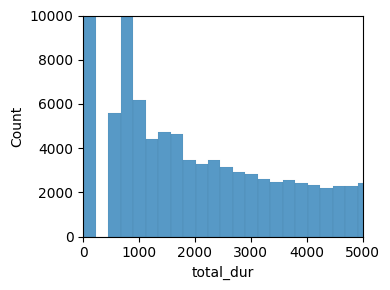

In [58]:
week2_test.loc[week2_test["total_dur"] < 500, "total_dur"] = 0

sns.histplot(week2_test.total_dur, bins=1000)
plt.axis(xmin=0, xmax=5000, ymax=10000)
plt.tight_layout();


Модель показала себя лучше, чем в группе B на 2.5%, причем эффект распространился на 10% самых смотрящих пользователей.

=> Поэтому докину эффект 2.5% для топ-10 смотрящих пользователей в группу B

In [60]:
salt = "kiontestmodel20210805"

week2_groups = groups_splitter(week2_test, ["user_id", "total_dur", "group"], user_salt=salt)
week2_groups.total_dur = week2_groups.total_dur.astype(float)

In [63]:
# отсортирую по total_dur
week2_groups = week2_groups.sort_values("total_dur")

pd.concat([week2_groups.head(3), week2_groups.tail(3)], axis=0)

,user_id,total_dur,group
223506,803922,0.0,B
61999,231833,0.0,A
62000,231838,0.0,B
57132,214158,223396.0,B
76042,281449,223477.0,A
24122,1085683,223485.0,B


In [68]:
group_b = week2_groups[week2_groups.group == "B"]
top_10_watchers_group_b = group_b.index[int(len(group_b) * 0.9) :]

In [70]:
# Effect for B group
effect = 1.025
week2_groups.loc[top_10_watchers_group_b, "total_dur"] *= effect

pd.concat([week2_groups.head(3), week2_groups.tail(3)], axis=0)

,user_id,total_dur,group
223506,803922,0.000,B
61999,231833,0.000,A
62000,231838,0.000,B
57132,214158,228980.900,B
76042,281449,223477.000,A
24122,1085683,229072.125,B


In [102]:
metric_column = "total_dur"
alpha = 0.05

vec_a = week2_groups[(week2_groups['group'] == 'A')][metric_column]
vec_b = week2_groups[(week2_groups['group'] == 'B')][metric_column]

sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
diff_mean = sample_b_mean - sample_a_mean

left_side, right_side = np.percentile(diff_mean, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
print((left_side, right_side))
print("H_0 отвергнута:", not left_side < 0 < right_side)

(18.421093750000004, 445.92226562499997)
H_0 отвергнута: True


**Вывод**:

С вероятностью 95% математическое ожидание разностей средних групп A и B лежит правее нуля, поэтому мы отвергаем нулевую гипотезу ```H_0``` об отсутствии изменеий между группами и принимаем альтернитивную гипотезу ```H_a``` о наличии эффекта между группами A и B.

При $\alpha = 0.05$ и $\beta = 0.2$ минимальный задетектированный эффект составил ```0.9%```

# ДЗ 1:

### Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага

СОВЕТ: Т.к бутстрэп считается долго, то для дз отлаживаем код на малом количестве итераций, а результаты уже показываем на 1000+